In [1]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)

In [4]:
df["gt overlap norm GT area"]=df["gt overlap area"]/df["GT area"]
df["gt overlap norm tarea"]=df["gt overlap area"]/df["tile area"]

# Tile overlap distribution analysis

In [5]:
def plot_tile_overlap_distribution(batch,objid,small_tiles=True):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    avrg_tarea = df_tile_subset["tile area"].mean()
    if small_tiles: df_tile_subset = df_tile_subset[df_tile_subset["tile area"]<avrg_tarea]
    ydata  = df_tile_subset["tile area"]-df_tile_subset["gt overlap area"]
    xdata  = df_tile_subset["gt overlap area"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("{}; obj{}".format(batch,objid))
    if small_tiles: plt.title("{}; obj{} [small tiles only]".format(batch,objid))
    plt.scatter(xdata,ydata,marker='.',label="Tile")
    partial_frac = len(np.where((xdata!=0)&(ydata!=0))[0])/float(len(ydata))*100
    plt.text(0.87, 0.75,"Partial:{:.2f}%".format(partial_frac),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.85, 0.70,"Area Cutoff:{:.2f}".format(avrg_tarea),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.87, 0.65,"Total Tiles:{}".format(len(ydata)),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    x = np.linspace(0,xdata.max())
    def f(x,alpha=1.):
        return alpha*x
    plt.plot(x,f(x),'--',color='red',label="y=x")
    #plt.plot(x,f(x,0.2),'--',color='green',label="y=0.2x")
    # plt.plot(x,f(x,1.2),'--',color='green',label="y=1.2x")
    plt.legend(loc='upper right')
    plt.xlabel("Intersection area",fontsize=13)
    plt.ylabel("Outside area",fontsize=13)

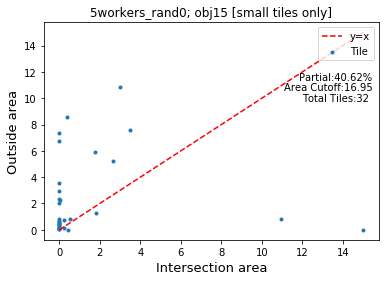

In [10]:
plot_tile_overlap_distribution( '5workers_rand0',15)

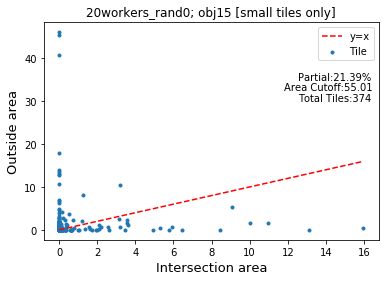

In [11]:
plot_tile_overlap_distribution('20workers_rand0',15)

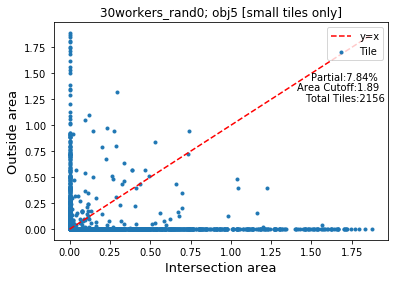

In [12]:
plot_tile_overlap_distribution('30workers_rand0',5)

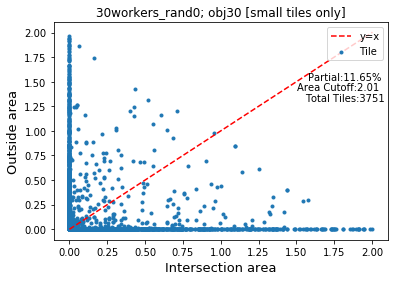

In [13]:
plot_tile_overlap_distribution('30workers_rand0',30)

# Voted Colored Distribution

In [14]:
def plot_vote_colored_tile_overlap_distribution(batch,objid,small_tiles=True):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    avrg_tarea = df_tile_subset["tile area"].mean()
    if small_tiles: df_tile_subset = df_tile_subset[df_tile_subset["tile area"]<avrg_tarea]
    ydata  = df_tile_subset["tile area"]-df_tile_subset["gt overlap area"]
    xdata  = df_tile_subset["gt overlap area"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title("{}; obj{}".format(batch,objid))
    if small_tiles: plt.title("{}; obj{} [small tiles only]".format(batch,objid))
    plt.scatter(xdata,ydata,marker='.',label="Tile")
    partial_frac = len(np.where((xdata!=0)&(ydata!=0))[0])/float(len(ydata))*100
    plt.text(0.87, 0.75,"Partial:{:.2f}%".format(partial_frac),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.85, 0.70,"Area Cutoff:{:.2f}".format(avrg_tarea),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    plt.text(0.87, 0.65,"Total Tiles:{}".format(len(ydata)),horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)
    x = np.linspace(0,xdata.max())
    def f(x,alpha=1.):
        return alpha*x
    plt.plot(x,f(x),'--',color='red',label="y=x")
    #plt.plot(x,f(x,0.2),'--',color='green',label="y=0.2x")
    # plt.plot(x,f(x,1.2),'--',color='green',label="y=1.2x")
    plt.legend(loc='upper right')
    plt.xlabel("Intersection area",fontsize=13)
    plt.ylabel("Outside area",fontsize=13)

In [ ]:
if small_tiles: df_tile_subset = df_tile_subset[df_tile_subset["tile area"]<avrg_tarea]

In [37]:
selected

,batch,objid,tile id,tile area,gt overlap area,worker id,Num Points,Area Ratio,P [GT],R [GT],...,R [MVT],J [MVT],GT area,GT num Points,is_hard,is_task_ambiguity,is_small_area,is_high_numPts,gt overlap norm GT area,gt overlap norm tarea
2305,30workers_rand0,5,0,2085.932167,2078.159686,9,21,0.01161,0.927076,0.846388,...,0.913875,0.89065,3906.5,21,True,False,False,True,0.531975,0.996274


ValueError: min() arg is an empty sequence

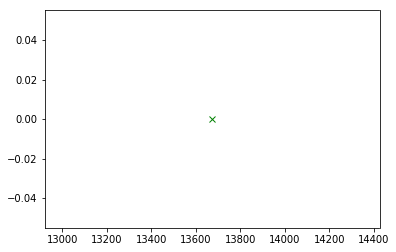

In [40]:
batch = '30workers_rand0'
objid = 10
split=[0.7,0.85]
delta=0.03
bin2size={0:'small',1:'medium',2:'large'}
df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
tile_lst = np.array(list(set(df_tile_subset["tile id"])))
tile_area = list(set(df_tile_subset["tile area"]))
bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
bin_idx = np.digitize(tile_area,bin_edges)
# for size in list(set(bin_idx)):
# fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
# idx = np.where(bin_idx==size)[0]

for tidx in tile_lst:#[idx]:
    yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
    selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(df_tile_subset["worker id"].isin(yes_workers))]
    no_selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(~df_tile_subset["worker id"].isin(yes_workers))]

    ydata = selected['tile area']-selected['gt overlap area']
    xdata = selected["gt overlap area"]
    plt.plot(xdata,ydata,'x',color='green')
    
    ydata = no_selected['tile area']-no_selected['gt overlap area']
    xdata = no_selected["gt overlap area"]
    plt.plot(xdata,ydata,'.',color='red')

    ymin,ymax= ax.get_ylim()
    ax.set_ylim(min(ydata)-delta,split[0]) # Definition of bad workers
    ax2.set_ylim(split[1],max(ydata)+delta)# Definition of good workers
plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
# fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
# fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
# fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)

plt.xlim(-0.1,1.1)

plt.tight_layout()

### [*]compare with where MV does wrong 

# Worker Quality 

we only show this for tiles that are highly voted by many workers 

In [23]:
# df = df_worker.merge(df_tile)
# def plot_overlap_vs_worker_quality(batch,objid,y_attr):
#     df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
#     df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
#     tile_lst = list(set(df_tile_subset["tile id"]))
#     for tidx in tile_lst:
#         yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
#         selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(df_tile_subset["worker id"].isin(yes_workers))]
#         no_selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(~df_tile_subset["worker id"].isin(yes_workers))]
#         if len(no_selected)>0:
#             xdata = no_selected['gt overlap area']/no_selected['tile area']
#             ydata = no_selected[y_attr]
#             plt.plot(xdata,ydata,'.',color='red')
#         if len(selected)>0:
#             xdata = selected['gt overlap area']/selected['tile area']
#             ydata = selected[y_attr]
#             plt.plot(xdata,ydata,'x',color='green')

#     plt.title("{}; obj{}".format(batch,objid))
#     plt.xlabel("overlap fraction",fontsize=13)
#     plt.ylabel(y_attr,fontsize=13)
#     plt.xlim(0,1.1)
#     plt.legend(['unvoted','voted'],loc="lower right",fontsize=12)

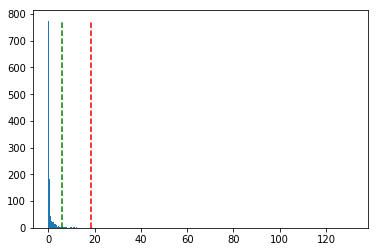

In [99]:
a = plt.hist(tile_area,bins=500)
plt.vlines(np.percentile(tile_area,95),0,a[0].max(),linestyles='--',colors='green')
plt.vlines(np.percentile(tile_area,99),0,a[0].max(),linestyles='--',colors='red')

In [8]:
def plot_overlap_vs_worker_quality(batch,objid,y_attr,split=[0.7,0.85],delta=0.03):
    bin2size={0:'small',1:'medium',2:'large'}
    df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    tile_area = list(set(df_tile_subset["tile area"]))
    bin_edges = [np.percentile(tile_area,95),np.percentile(tile_area,99)]
    bin_idx = np.digitize(tile_area,bin_edges)
    for size in list(set(bin_idx)):
        fig,(ax,ax2) = plt.subplots(1, 2, sharex=True)
        idx = np.where(bin_idx==size)[0]
        for tidx in tile_lst[idx]:
            yes_workers= df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values
            selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(df_tile_subset["worker id"].isin(yes_workers))]
            no_selected = df_tile_subset[(df_tile_subset["tile id"]==tidx)&(~df_tile_subset["worker id"].isin(yes_workers))]

            xdata1 = no_selected['gt overlap area']/no_selected['tile area']
            ydata1 = no_selected[y_attr]
            #plt.plot(xdata,ydata,'.',color='red')

            ax.plot(xdata1, ydata1,'.',color='red')
            ax2.plot(xdata1, ydata1,'.',color='red')

            xdata = selected['gt overlap area']/selected['tile area']
            ydata = selected[y_attr]
            #plt.plot(xdata,ydata,'x',color='green')
            ax.plot(xdata, ydata,'x',color='green')
            ax2.plot(xdata, ydata,'x',color='green')

            ymin,ymax= ax.get_ylim()
            ax.set_ylim(min(ydata1)-delta,split[0]) # Definition of bad workers
            ax2.set_ylim(split[1],max(ydata1)+delta)# Definition of good workers
        plt.legend(['unvoted','voted'],bbox_to_anchor=(1.7,1), loc="upper right",fontsize=12)
        fig.text(0.5, 1,"{}; obj{} [{}]".format(batch,objid,bin2size[size]), ha='center',fontsize=14)
        fig.text(0.5, 0, 'overlap fraction', ha='center',fontsize=13)
        fig.text(0.0, 0.5,y_attr, va='center', rotation='vertical',fontsize=13)

        plt.xlim(-0.1,1.1)

        plt.tight_layout()

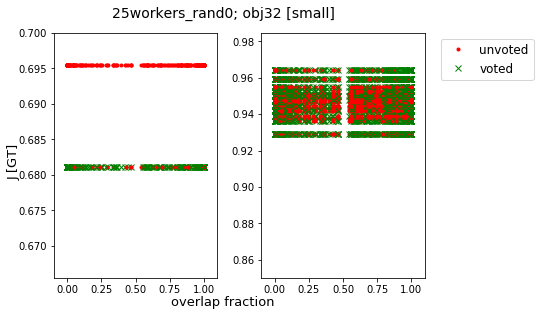

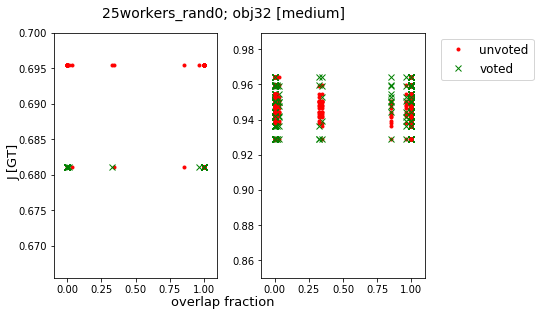

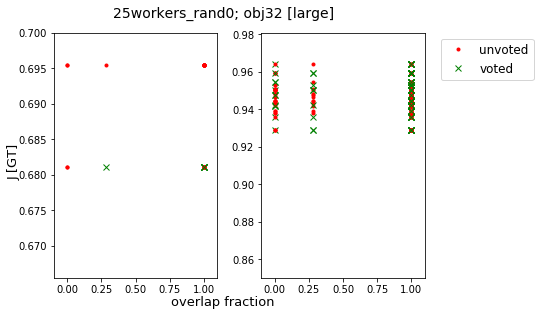

In [174]:
plot_overlap_vs_worker_quality('25workers_rand0',32,'J [GT]')

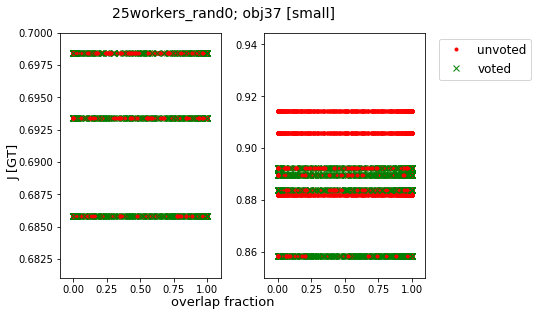

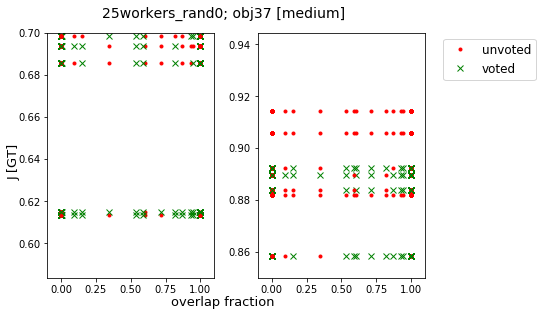

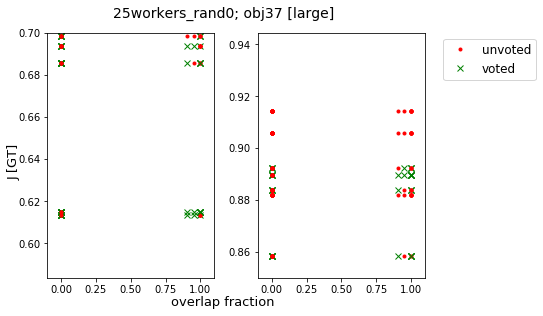

In [173]:
plot_overlap_vs_worker_quality('25workers_rand0',37,'J [GT]')

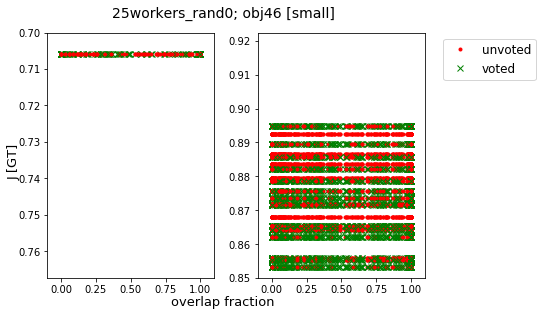

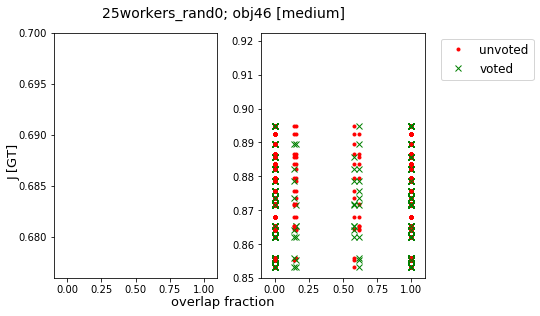

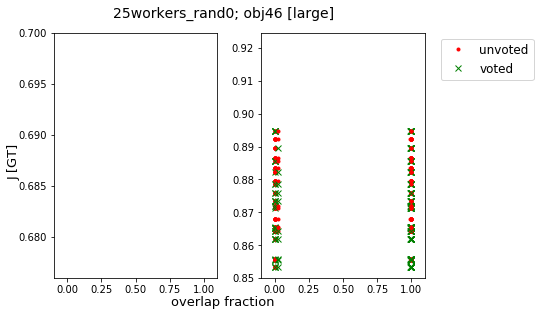

In [172]:
plot_overlap_vs_worker_quality('25workers_rand0',46,'J [GT]')

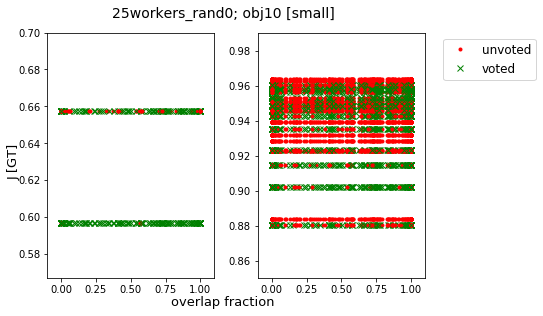

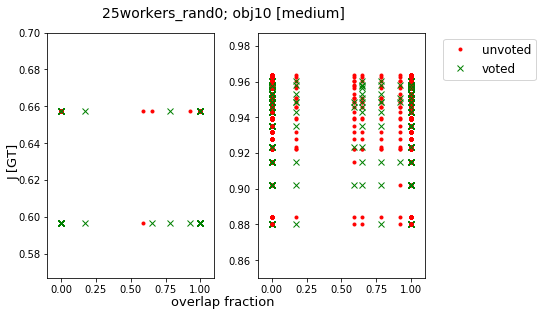

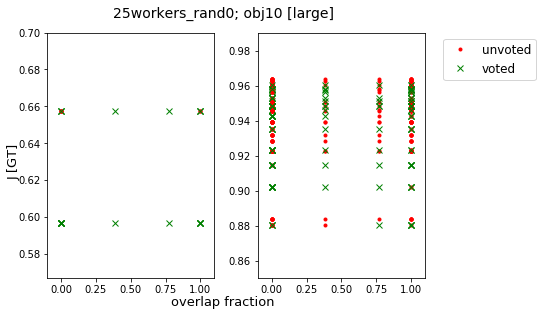

In [166]:
plot_overlap_vs_worker_quality('25workers_rand0',10,'J [GT]')

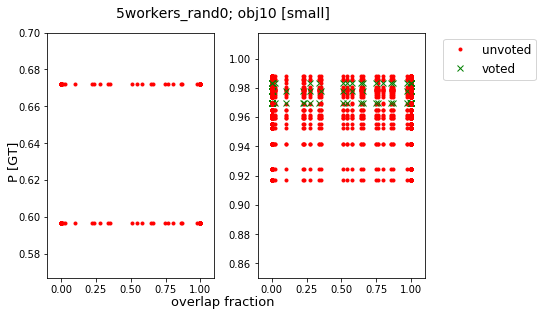

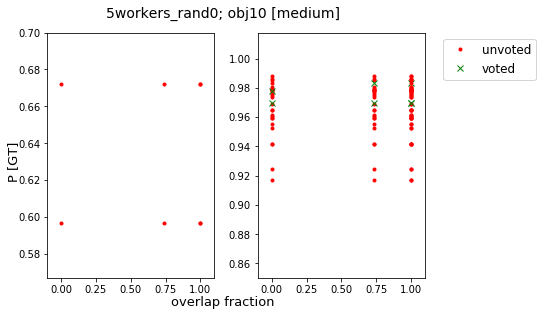

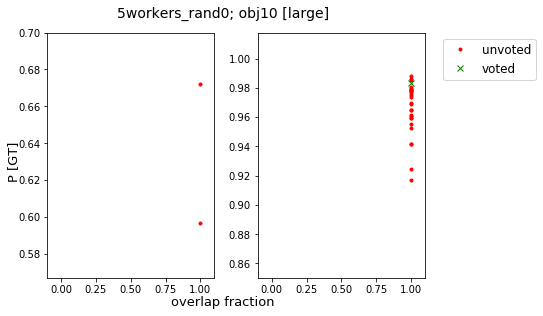

In [175]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'P [GT]')

##### convergence of worker qualities (i.e. picked the same tiles combination) is higher for tiles which are completely inside or outside (i.e. overlap fractions of 0 or 1)

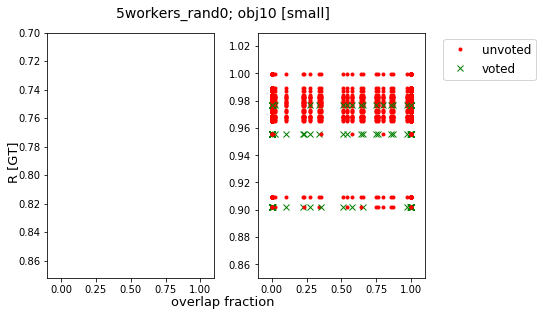

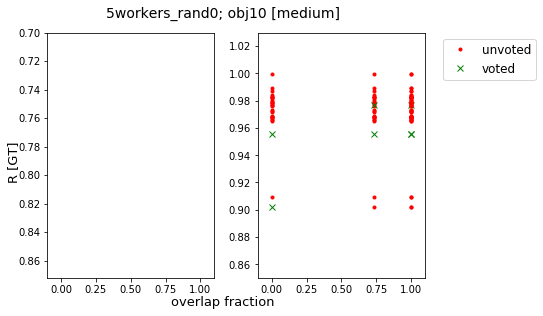

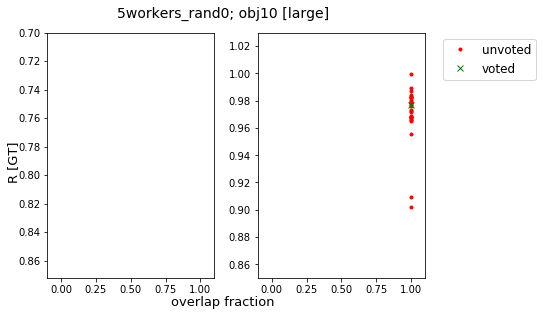

In [176]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'R [GT]')

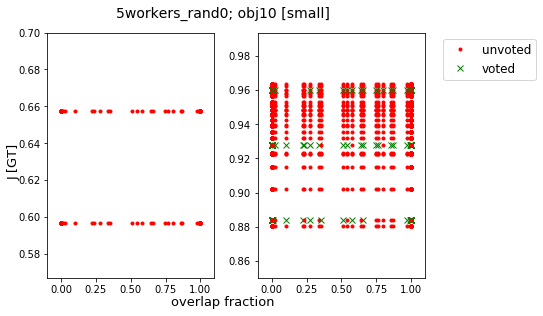

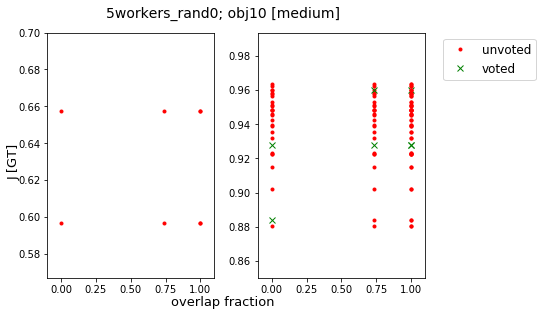

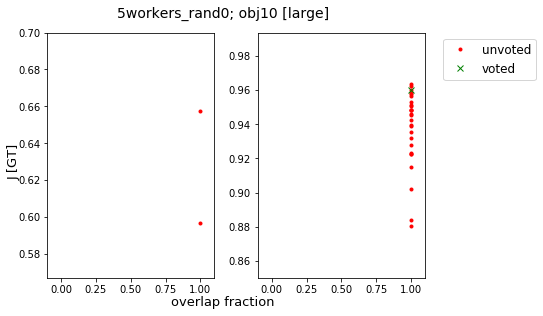

In [177]:
plot_overlap_vs_worker_quality('5workers_rand0',10,'J [GT]')

- ~~separate by small tile, medium tile and large tiles~~

- [*] what is the turnover where worker switch from red to green? 

Each vertical line represents a tile. Every horizontal line represents a worker. 

In [11]:
# df = df_worker.merge(df_tile)
# def plot_overlap_vs_area_weighted_prob(batch,objid):
#     df_tile_subset = df[(df["batch"]==batch)&(df["objid"]==objid)]
#     df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
#     tile_lst = list(set(df_tile_subset["tile id"]))
#     image_area = float(df_object[df_object["objid"]==objid]["Image area"])
#     for tidx in tile_lst:
#         yes_workers= list(set(df_worker_tile_subset[(df_worker_tile["tile id"]==tidx)]["worker id"].values))
#         no_workers= list(set(df_worker_tile_subset[(df_worker_tile["tile id"]!=tidx)]["worker id"].values))
#         weighted_area = 0
#         for wid in list(set(df_tile_subset["worker id"])):
#             df_this = df_tile_subset[(df_tile_subset["worker id"]==wid)&(df_tile_subset["tile id"]==tidx)]
#             if wid in no_workers:
#                 weighted_area+= (float(df_this["tile area"].values) - float(df_this["gt overlap area"].values))
#             elif wid in yes_workers:
#                 weighted_area+=float(df_this["gt overlap area"].values)
#         weighted_qj = weighted_area/image_area
#         xdata = float(df_this['gt overlap area'])/float(df_this['tile area'])
#         plt.plot(xdata,weighted_qj,'o',color="blue")
#     plt.title("{}; obj{}".format(batch,objid))
#     plt.xlabel("overlap fraction",fontsize=13)
#     plt.ylabel("area-weighted prob of tile correct",fontsize=13)
#     plt.xlim(0,1.1)
#     plt.legend(['worker vote on tile'],loc="upper left",fontsize=12)

In [10]:
batch = '5workers_rand0'
wid = 196
df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
weighted_qj_tbl = []
for objid in list(set(df_object["objid"])):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    image_area = float(df_object[df_object["objid"]==objid]["Image area"])
    df_worker_tile_subset = df_worker_tile[(df_worker_tile["batch"]==batch)&(df_worker_tile["objid"]==objid)]
    tile_lst = list(set(df_worker_tile_subset["tile id"]))
    for wid in list(set(df_worker_tile_subset["worker id"])):#list(set(df_worker["worker id"])):
        voted_tiles = list(df_worker_tile_subset[df_worker_tile_subset["worker id"]==wid]["tile id"])
        if len(voted_tiles)>0:
            non_voted_tiles =[t for t in tile_lst if t not in voted_tiles]
            voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(voted_tiles)]["gt overlap area"].sum()
            non_voted_area_term = df_tile_subset[df_tile_subset["tile id"].isin(non_voted_tiles)]["outside area"].sum()
            weighted_qj =(non_voted_area_term+voted_area_term)/image_area
            weighted_qj_tbl.append([wid,weighted_qj])

weighted_qj_tbl = pd.DataFrame(weighted_qj_tbl,columns=["worker id","weighted qj"])

df_worker = df_worker.merge(weighted_qj_tbl)

In [12]:
df = df_worker.merge(df_tile)

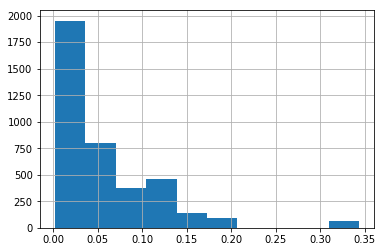

In [16]:
df_worker["weighted qj"].hist()

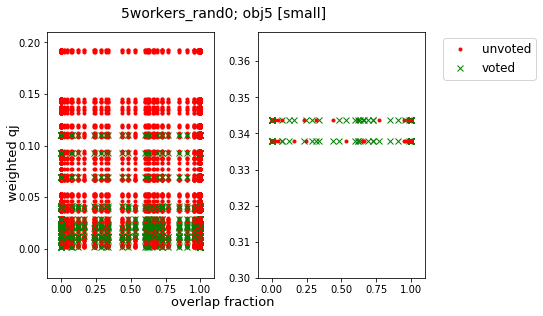

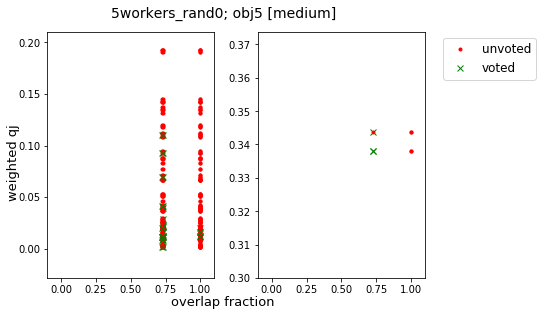

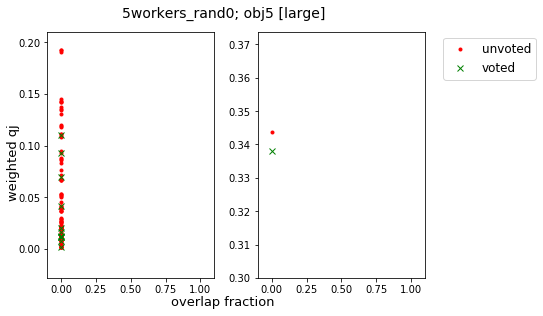

In [17]:
plot_overlap_vs_worker_quality('5workers_rand0',5,"weighted qj",[0.21,0.3])

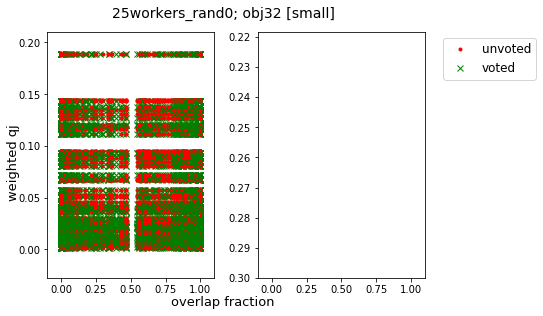

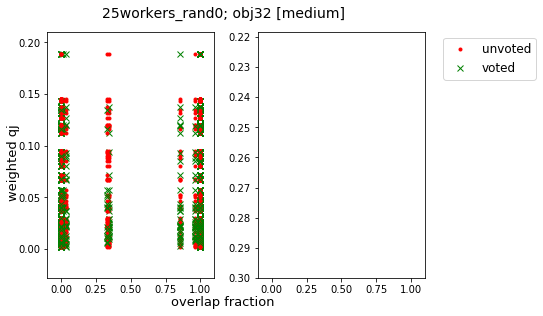

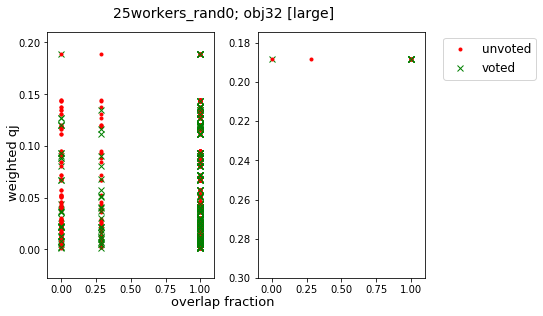

In [19]:
plot_overlap_vs_worker_quality('25workers_rand0',32,"weighted qj",[0.21,0.3])

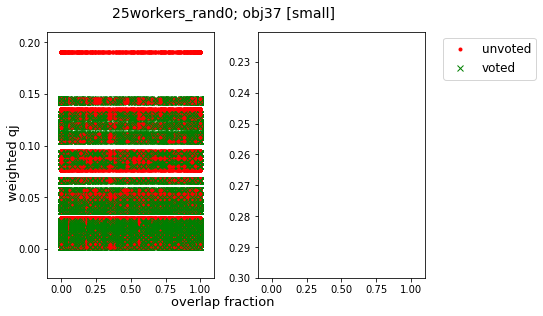

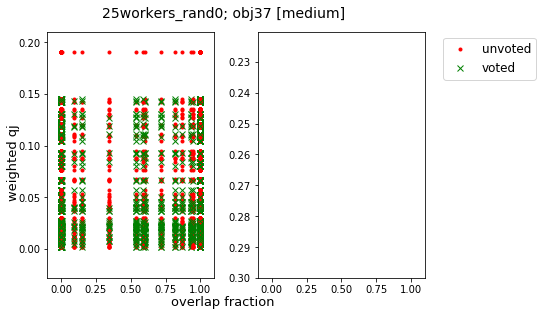

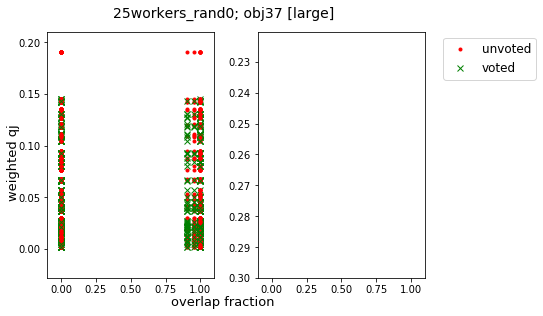

In [20]:
plot_overlap_vs_worker_quality('25workers_rand0',37,"weighted qj",[0.21,0.3])

# Histogram of mistakes: 
- treat if overlap fraction >0.5 then we pick it, what is the accumlated area of mistake (of the external area) that we would make 
- start off by saying that > 0.5 overlap we pick, so "error area" = outside area of the tile, and <= 0.5 overlap we discard the tile in which case "error area" = intersection area.

In [55]:
def plot_mistake_histogram(batch,objid,small_tiles=True):
    df_tile["tile overlap frac"]=df_tile["gt overlap area"]/df_tile["tile area"]
    df_tile["outside area"]=df_tile["tile area"]-df_tile["gt overlap area"]
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]
    tile_lst = np.array(list(set(df_tile_subset["tile id"])))
    # tile_area = list(set(df_tile_subset["tile area"]))
    # tile_outside_area = list(set(df_tile_subset["outside area"]))
    mistake_area = []
    mistake_area_overselect = []
    mistake_area_discard = []
    mistake_count =[]
    for tidx in tile_lst:
        df_selected = df_tile_subset[df_tile_subset["tile id"]==tidx]
        if float(df_selected["tile overlap frac"])>=0.5:
            mistake_area.append(float(df_selected["gt overlap area"]))
            mistake_area_overselect.append(float(df_selected["gt overlap area"]))
            mistake_count.append(float(df_selected["tile area"]))
        else: 
            mistake_area.append(float(df_selected["outside area"]))
            mistake_area_discard.append(float(df_selected["outside area"]))
            mistake_count.append(float(df_selected["tile area"]))
    plt.figure()
    plt.title("Selected Mistake Histogram")
    if small_tiles: 
        a = plt.hist([mistake_area_discard,mistake_area_overselect],range=(0,mean(mistake_area)),bins=30)
    else:
        a = plt.hist([mistake_area_discard,mistake_area_overselect],bins=30)
    plt.legend(['discard','overselect'],fontsize=13)
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Count",fontsize=13)
    plt.figure()
    plt.title("Total Mistake Histogram")
    if small_tiles: 
        a = plt.hist(mistake_area,range=(0,mean(mistake_area)),bins=30)
    else:
        a = plt.hist(mistake_area,bins=30)
    plt.xlabel("Tile Area",fontsize=13)
    plt.ylabel("Count",fontsize=13)

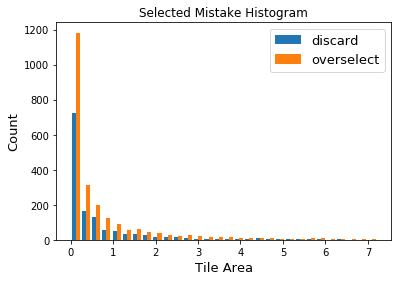

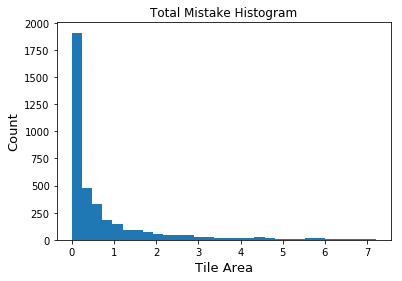

In [56]:
plot_mistake_histogram('30workers_rand0',1)

look at 5 and 10 , less small tiles 

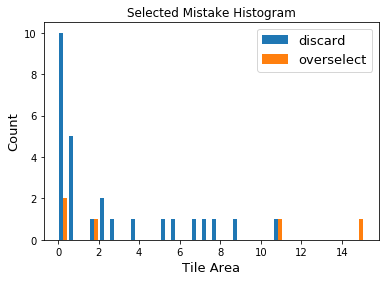

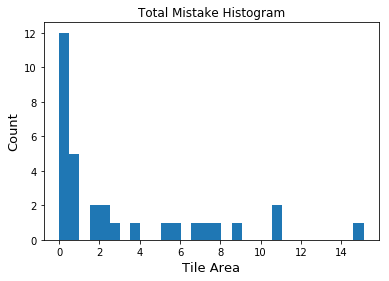

In [54]:
plot_mistake_histogram('5workers_rand0',15)

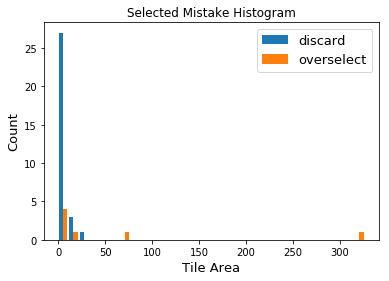

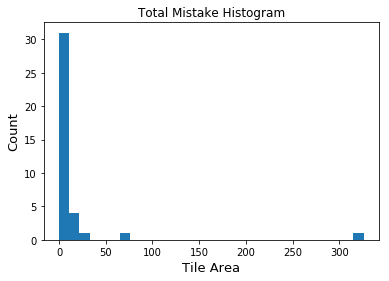

In [57]:
plot_mistake_histogram('5workers_rand0',15,False)

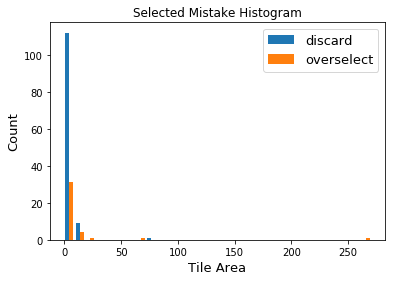

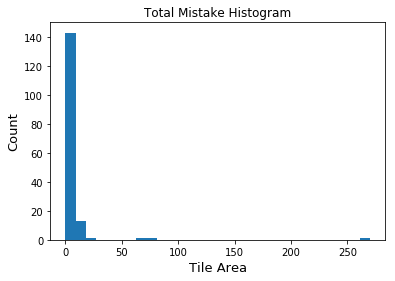

In [59]:
plot_mistake_histogram('10workers_rand0',15,False)